<a href="https://colab.research.google.com/github/ianbernardino/Quantitative-Finance-Models/blob/master/Modelos_CAPM_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INPUT VARIABLES**

In [ ]:
# Import libraries

import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format # Define the number style
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn') # Define plot style
# plt.rcParams['axes.facecolor'] = 'white' # Define plots background color
import seaborn as sns
!pip install yfinance --upgrade --no-cache-dir # Yahoo Finance Installation
import yfinance as yf
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

# Define Risk Free Asset (CDI) Return and Risk

# Taxa Anual
rf_return = 0.029
rf_risk = 0
rf = [rf_return, rf_risk]

# Taxa Diária
exp = (rf_return ** 1/252)
rfd_ret = (1 + exp) -1
rfd = [rfd_ret, rf_risk]

# Define input variable of stock ticker

print('Enter the Company Ticker:')

ticker = input()+".SA"
steps = int(input())

print("Company ticker: ",ticker)
print("Forecasting days: ",steps)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=b52fb998108f635b3a9eadd02bfc2f8e9e7ef52368606ee540a8b5b4103c0252
  Stored in directory: /tmp/pip-ephem-wheel-cache-0zzkqhuq/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance
Enter the Company Ticker:
BBDC4
10
Company ticker:  BBDC4.SA
Forecasting days:  10


# **DATA MODEL**

[*********************100%***********************]  2 of 2 completed


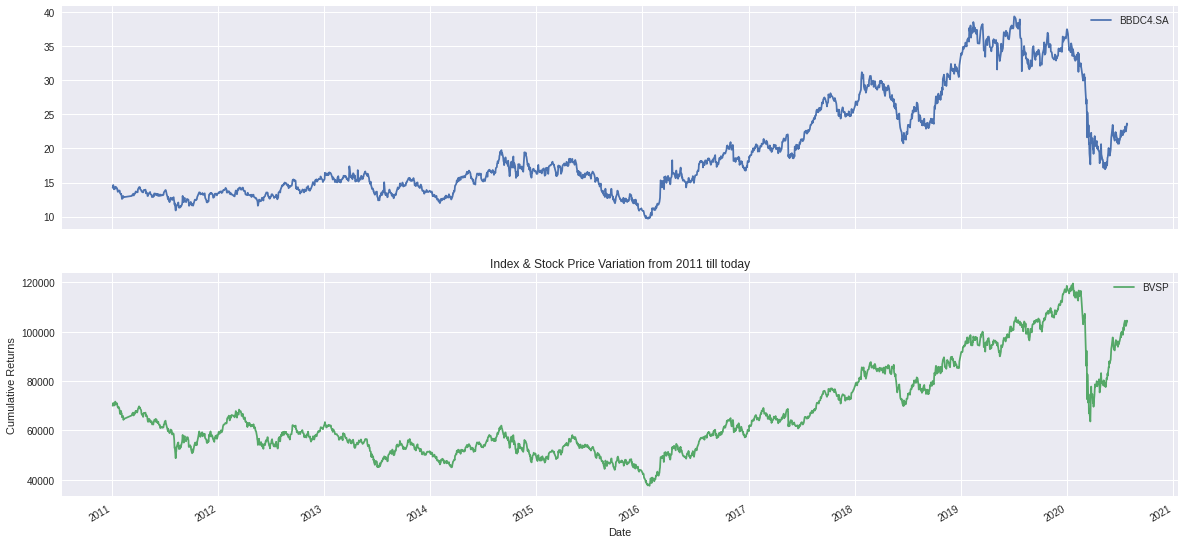

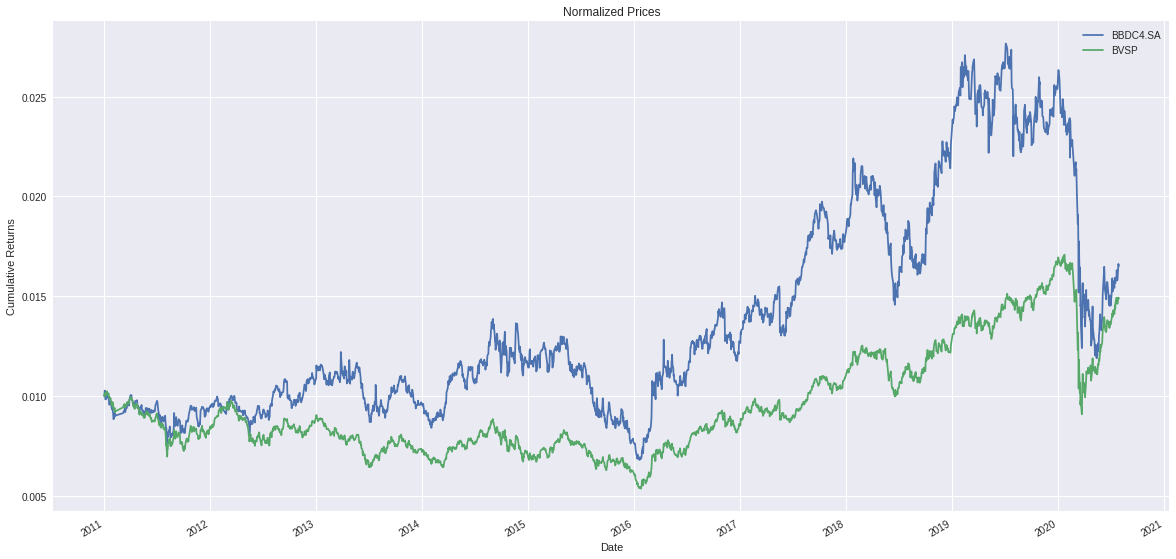

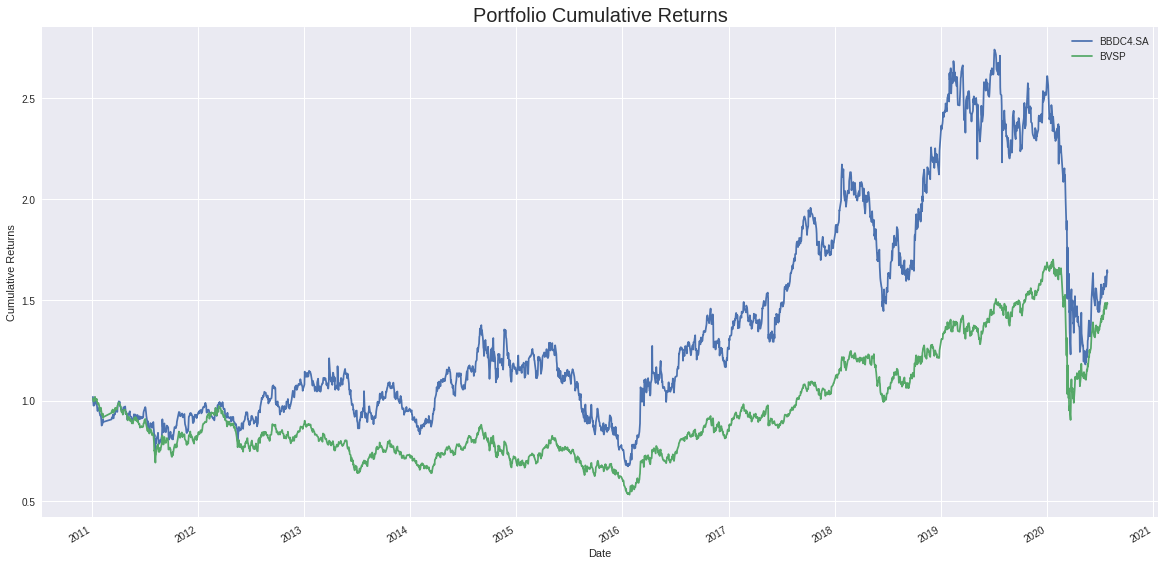

In [ ]:
# import constituents

tickers = [ticker, "^BVSP"]
stocks = yf.download(tickers, start = "2011-01-01")

# Select Closing Prices

stocks = stocks["Close"].copy().dropna()

# Rename columns

stocks.columns = [ticker, "BVSP"]

# Normalized series of Prices

norm = stocks.div(stocks.iloc[0].mul(100))

# Plot Time Series

stocks.plot(figsize=(20,10), subplots = True)
plt.title("Index & Stock Price Variation from 2011 till today")#, color = "white")
plt.xlabel('Date')#, color = "white")
plt.ylabel("Cumulative Returns")#, color = "white")
norm.plot(figsize=(20,10))
plt.title("Normalized Prices")#, color = "white")
plt.xlabel('Date')#, color = "white")
plt.ylabel("Cumulative Returns")#, color = "white")
plt.legend()
plt.show()

# Calculate returns of stock and Market Portfolio represented by BVSP and remove firt NA row

ret = stocks.pct_change().dropna()

# Calculate Cumulative Returns for constituents

cumulative_ret = ret[1:]
cumulative_ret = (cumulative_ret + 1).cumprod()

# Plot Cumulative Returns

cumulative_ret.plot(figsize=(20,10))
plt.xlabel('Date')#, color = "white")
plt.ylabel("Cumulative Returns")#, color = "white")
plt.title("Portfolio Cumulative Returns", fontsize = 20)#, color = "white")
plt.show()

# **CAPM Model**

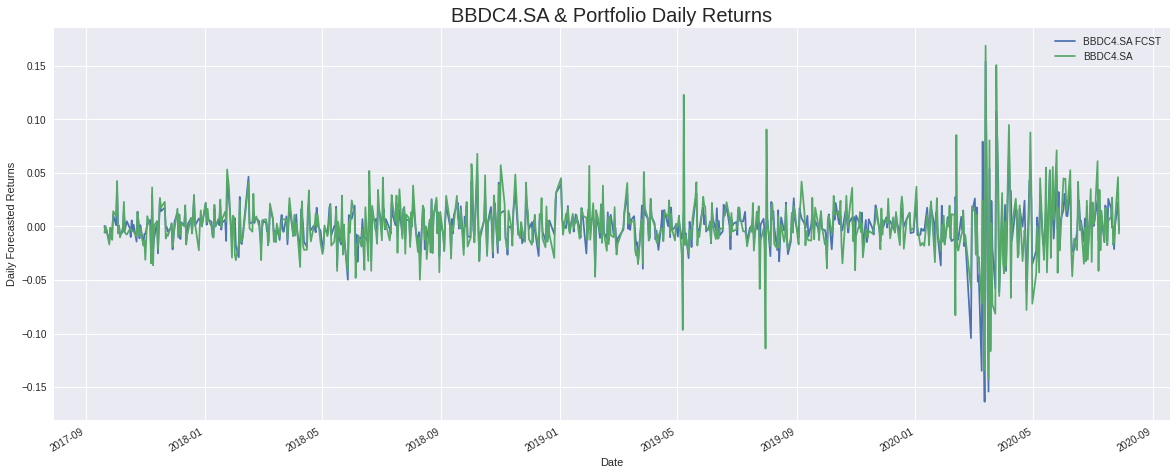

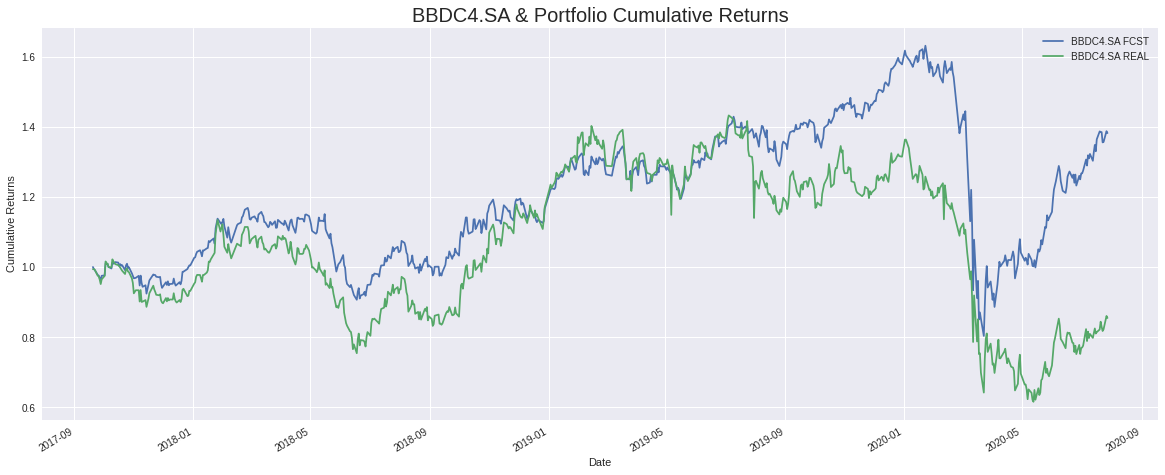

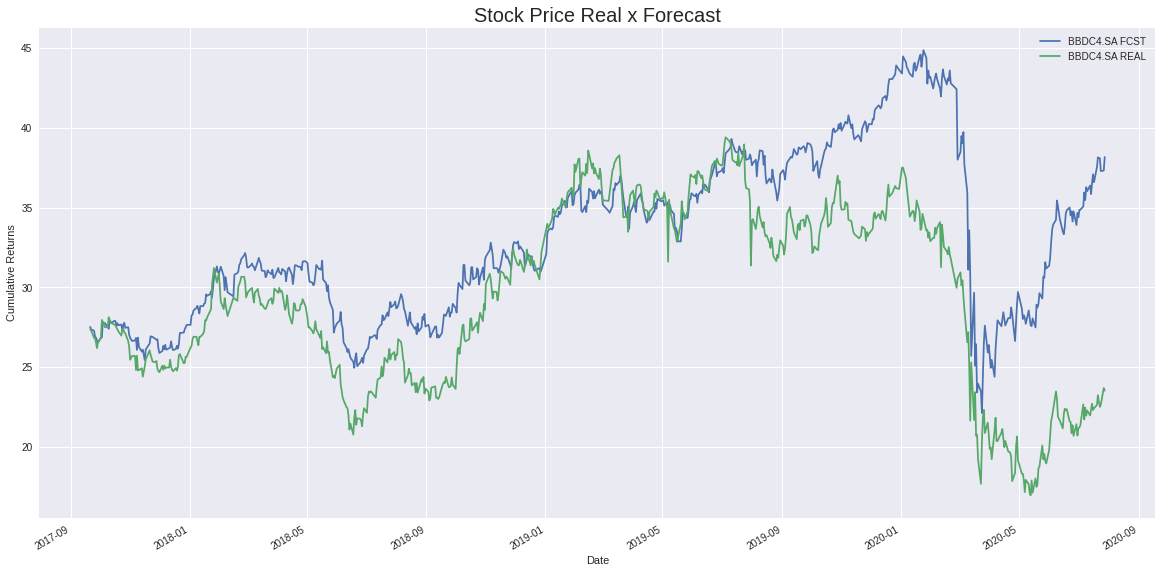

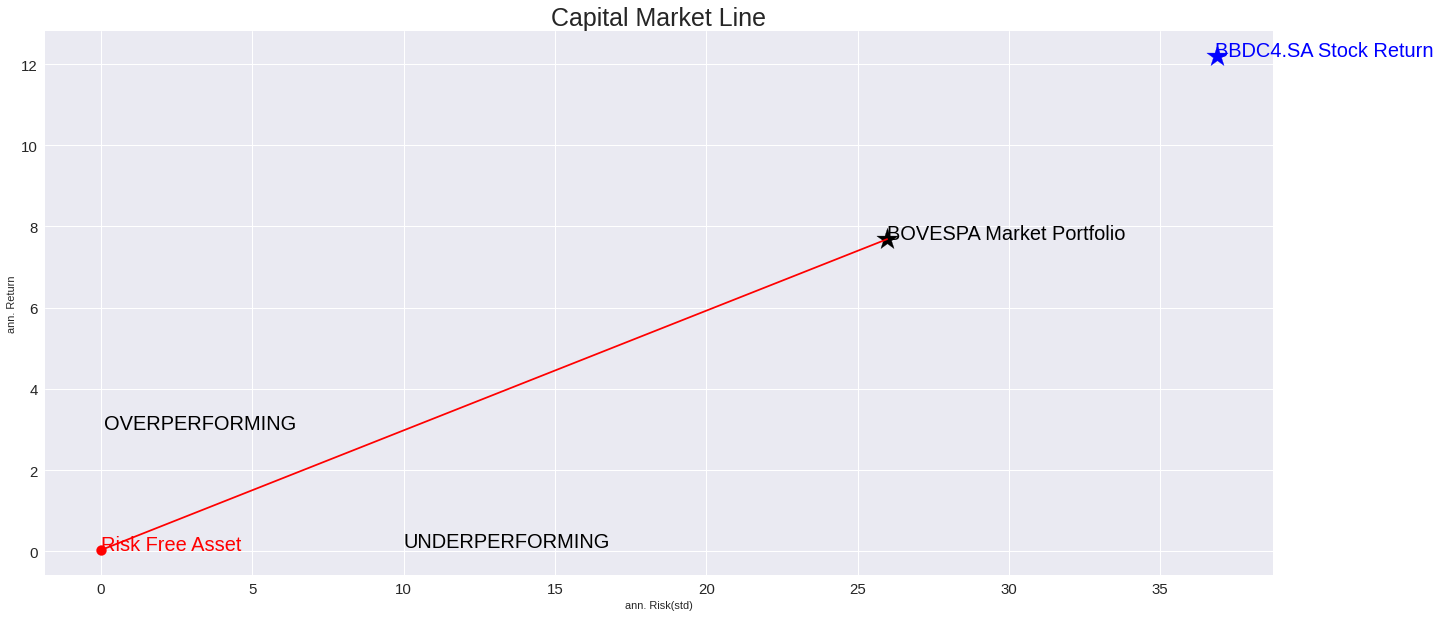

       BBDC4.SA        BVSP
count 2,337.000   2,337.000
mean     19.700  66,321.117
std       7.475  18,146.349
min       9.682  37,497.000
25%      13.820  53,176.000
50%      16.672  59,735.000
75%      23.992  76,402.000
max      39.410 119,528.000
ADF Statistic: -16.13161568981316
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject H0 - Time Series is Stationary
KPSS Statistic: 0.06753072172181979
p-value: 0.100000
If the computed statistic is outside the table of critical values, then a warning message will be generated.
Beta of the stock:  1.108
Model Test for Returns - MSE:  0.0003
Model Test for Price - MSE:  8317058187.6932


,Return,Risk,Sharpe,Total Risk_variance,SystRisk_var,UnSystRisk_var,beta,Expected Return,alpha
BBDC4.SA,12.202,36.873,25.226,13.596,7.543,6.053,111.765,8.251,3.950
BVSP,7.688,25.979,18.431,6.749,6.749,0.000,100.000,7.688,0.000


In [ ]:
# Test Train Split Supervised Learning
## train_size = .7
## test_size = .3

Y_ret = ret[ticker]
X_ret = ret.BVSP

# Model: Y = a + beta*BVSP_Excess_Return

X_train, X_test, y_train, y_test = train_test_split(X_ret, Y_ret, train_size = .7 , shuffle = False)

# Calculate beta of the model with train data
# Linear Regression to achieve beta: summary.beta = LR.beta

# numpy.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)

beta = np.polyfit(X_train, y_train, 1)[0]

# Excess Return of the Market Portfolio BVSP = ret.BVSP - rfd[0]
# Multiply Market Excess Returns Matrix for the beta of the constituent to apply forecast
# Sum the Risk Free Asset to the CAPM_Forecasted Excess Return to find Total Return of Forecast
# The result is the total returns of stocks based on BVSP variation

CAPM_Forecast = rfd[0] + (pd.DataFrame((X_test - rfd[0])) * (beta))

# Rename column 

CAPM_Forecast.columns = [ticker+" FCST"]

# Plot Forecasted Returns

CAPM_Forecast.plot(figsize=(20,8))
y_test.plot()
#plt.xticks(color = "white")
#plt.yticks(color = "white")
plt.xlabel('Date') #, color = "white")
plt.ylabel("Daily Forecasted Returns") #, color = "white")
plt.title(ticker+" & Portfolio Daily Returns", fontsize = 20) #, color = "white")
plt.legend()
plt.show()

# Calculate Forecasted Cumulative Returns

fcst_cumulative_ret = CAPM_Forecast
fcst_cumulative_ret = (fcst_cumulative_ret + 1).cumprod()
fcst_cumulative_ret[ticker+" REAL"] = (y_test + 1).cumprod()
#fcst_cumulative_ret["BVSP"] = (X_test + 1).cumprod()

# Plot Forecasted Cumulative Returns

fcst_cumulative_ret.plot(figsize=(20,8))
#plt.xticks(color = "white")
#plt.yticks(color = "white")
plt.xlabel('Date') #, color = "white")
plt.ylabel("Cumulative Returns") #, color = "white")
plt.title(ticker+" & Portfolio Cumulative Returns", fontsize = 20) #, color = "white")
plt.legend()
plt.show()

# Index first price of the stock in the test set

Y_val = stocks[ticker]
X_val = stocks.BVSP

X_hist, X_price, y_hist, y_price = train_test_split(X_val, Y_val, train_size = .7 , shuffle = False)

# Accumulate daily returns (CAPM_Forecast) and multiply by price (stock_price)

# Stock price is the first price of the test set
stock_price = y_price.iloc[0]

# FORECAST
test = pd.DataFrame(CAPM_Forecast.add(1).shift().cumprod()*stock_price)

# REAL
test[ticker+" REAL"] = stocks.iloc[:,0]
test = test.dropna()

# PLOT
test.plot(figsize=(20,10))
#plt.xticks(color = "white")
#plt.yticks(color = "white")
plt.xlabel('Date') #, color = "white")
plt.ylabel("Cumulative Returns") #, color = "white")
plt.title("Stock Price Real x Forecast", fontsize = 20) #, color = "white")
plt.legend()
plt.show()

# Define a function to calculate:
# RISK in Standard Deviation Units
# RETURN as Mean

def ann_risk_ret(return_df):
  summary = return_df.agg(["mean", "std"]).T
  summary.columns = ["Return", "Risk"]
  summary.Return = summary.Return * 252
  summary.Risk = summary.Risk * np.sqrt(252)
  return summary


# Calculate risk and return

summary = ann_risk_ret(ret)

# Calculate Sharpe Ratio

summary["Sharpe"] = (summary["Return"].sub(rf[0])) / summary["Risk"]

# Calculate Total Risk Variance = teta²

summary["Total Risk_variance"] = np.power(summary.Risk,2)

# Calculate covariance matrix for annualized returns

COV = ret.cov()*252

# Calculate Systematic (Covariance) & Unsystematic Risk

summary["SystRisk_var"] = COV.iloc[:,1] 
summary["UnSystRisk_var"] = summary["Total Risk_variance"].sub(summary["SystRisk_var"])

# Calculate beta: Cov(BVSP, Stock) / Var(BVSP)

summary["beta"] = summary.SystRisk_var / summary.loc["BVSP", "SystRisk_var"]

# Calculate Expected Return: CAPM Forecast

summary["Expected Return"] = rf[0] + (summary.loc["BVSP", "Return"] - rf[0]) * summary.beta

# Calculate Expected Return Error: alpha

summary["alpha"] = summary.Return.sub(summary["Expected Return"])

summary = summary.mul(100)

# Plot Capital Market Line

plt.figure(figsize = (22, 10))
plt.scatter(summary.loc[ticker, "Risk"], 
            summary.loc[ticker, "Return"],
            s= 500, 
            marker = "*", 
            c = "blue")
plt.annotate(ticker+" Stock Return", 
             xy=(summary.loc[ticker, "Risk"]-0.05, 
                 summary.loc[ticker, "Return"]-0.005), 
             size = 20, 
             color = "blue")
plt.scatter(summary.loc["BVSP", "Risk"], 
            summary.loc["BVSP", "Return"],
            s= 500, 
            c = "black", 
            marker = "*")
plt.annotate("BOVESPA Market Portfolio", 
             xy=(summary.loc["BVSP", "Risk"]+0.01, 
                 summary.loc["BVSP", "Return"]), 
             size = 20, 
             color = "black")
plt.scatter(rf[1], 
            rf[0], 
            s = 100, 
            marker = "o", 
            c = "red")
plt.annotate("Risk Free Asset", 
             xy = (rf[1], 
                   rf[0]+0.002), 
             size = 20, 
             color = "red")

plt.xlabel("ann. Risk(std)") 
           #color = "white")
plt.ylabel("ann. Return") 
           #color = "white")
plt.tick_params(axis = "both", 
                labelsize = 15)
plt.title("Capital Market Line", 
          fontsize = 25) #, color = "white")
plt.plot([rf[1], summary.loc["BVSP", "Risk"]], 
         [rf[0], summary.loc["BVSP", "Return"]], 
         c = "red")
plt.annotate("OVERPERFORMING", 
             xy = (0.1, 3), 
             size = 20, 
             color = "black")
plt.annotate("UNDERPERFORMING", 
             xy = (10, 0.1), 
             size = 20, 
             color = "black")
plt.xticks() #color = "white")
plt.yticks() #color = "white")
plt.show()
summary

# Descriptive Statistics

print(stocks.describe())

# Augmented Dickey-Fuller Stationarity test

adf = pd.Series(ret[ticker])
result = adfuller(adf)
print('ADF Statistic:', result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
  print("Reject H0 - Time Series is Stationary")
else:
  print ("Failed to Reject H0 - Time Series is Non-Stationary")

# Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

KPSS = pd.Series(stocks[ticker].diff().dropna())
result = kpss(KPSS)
print('KPSS Statistic:', result[0])
print('p-value: %f' % result[1])
print('If the computed statistic is outside the table of critical values, then a warning message will be generated.')

# BETA

print("Beta of the stock: ",round(beta,3))

# MEAN SQUARED ERROR

# Returns

ERRO_ret = mean_squared_error(X_test, y_test)
print('Model Test for Returns - MSE: ', round(ERRO_ret,4))

# Price

ERRO_price = mean_squared_error(X_price, y_price)
print('Model Test for Price - MSE: ', round(ERRO_price,4))
summary

# **ARIMA MODEL**

ADF Statistic: -16.13161568981316
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject H0 - Time Series is Stationary
KPSS Statistic: 0.05524420945922417
p-value: 0.100000
If the computed statistic is outside the table of critical values, then a warning message will be generated.
ARIMA BEST MODEL AIC: -7938.227928291565
ARIMA AR (p) =  0
ARIMA INT(d) =  0
ARIMA MA (q) =  3
                              ARMA Model Results                              
Dep. Variable:               BBDC4.SA   No. Observations:                 1635
Model:                     ARMA(0, 3)   Log Likelihood                3974.114
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 28 Jul 2020   AIC                          -7938.228
Time:                        23:35:57   BIC                          -7911.231
Sample:                             0   HQIC                         -7928.214
                                             

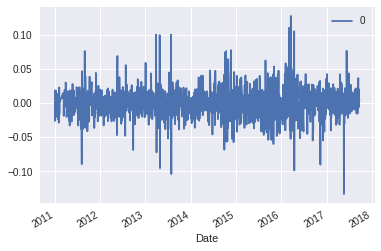

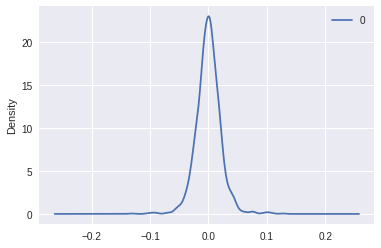

              0
count 1,635.000
mean      0.000
std       0.021
min      -0.133
25%      -0.011
50%       0.000
75%       0.012
max       0.127


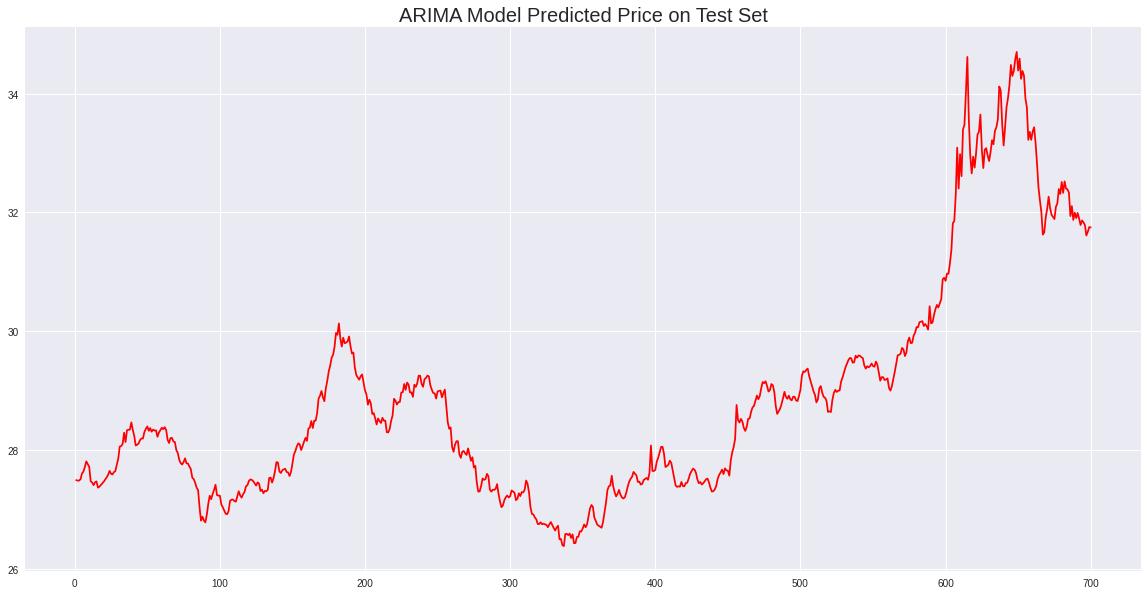

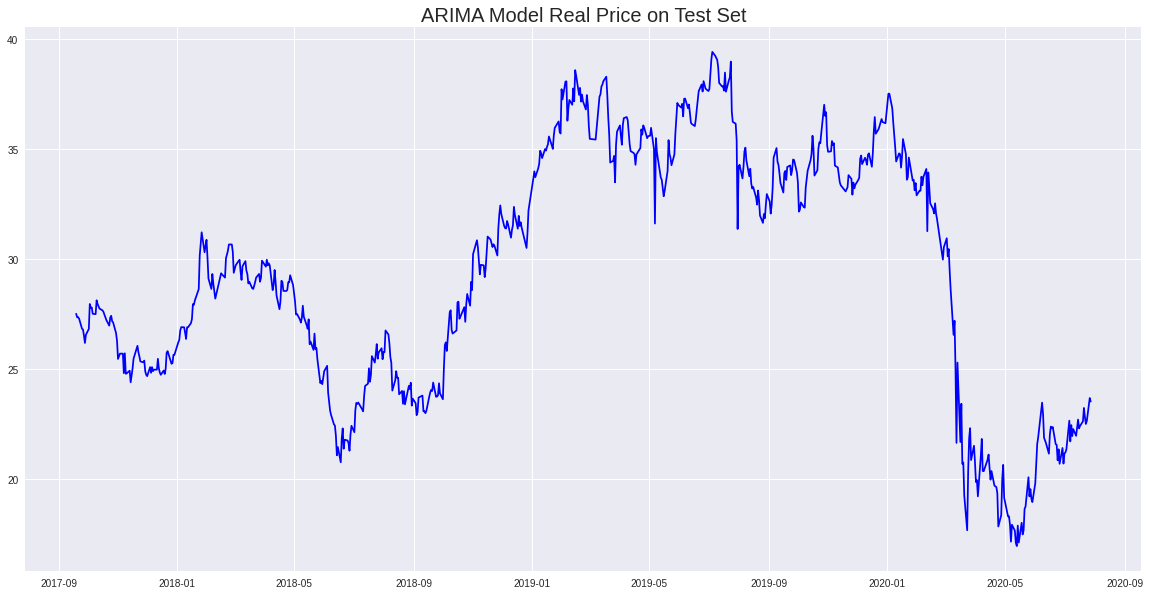

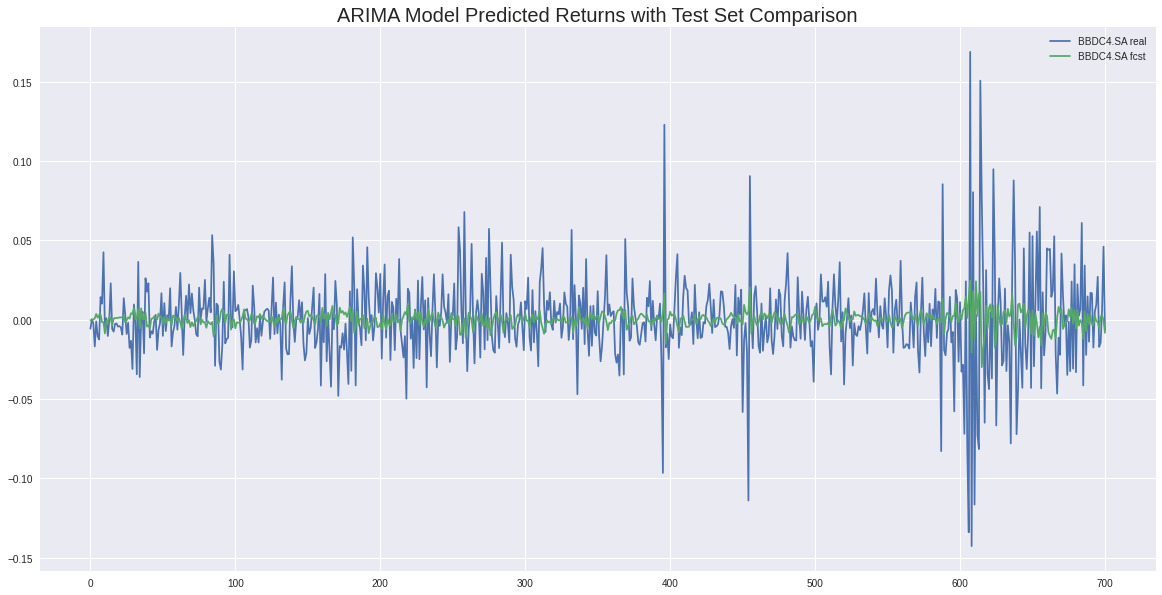

Test MSE: 49.211


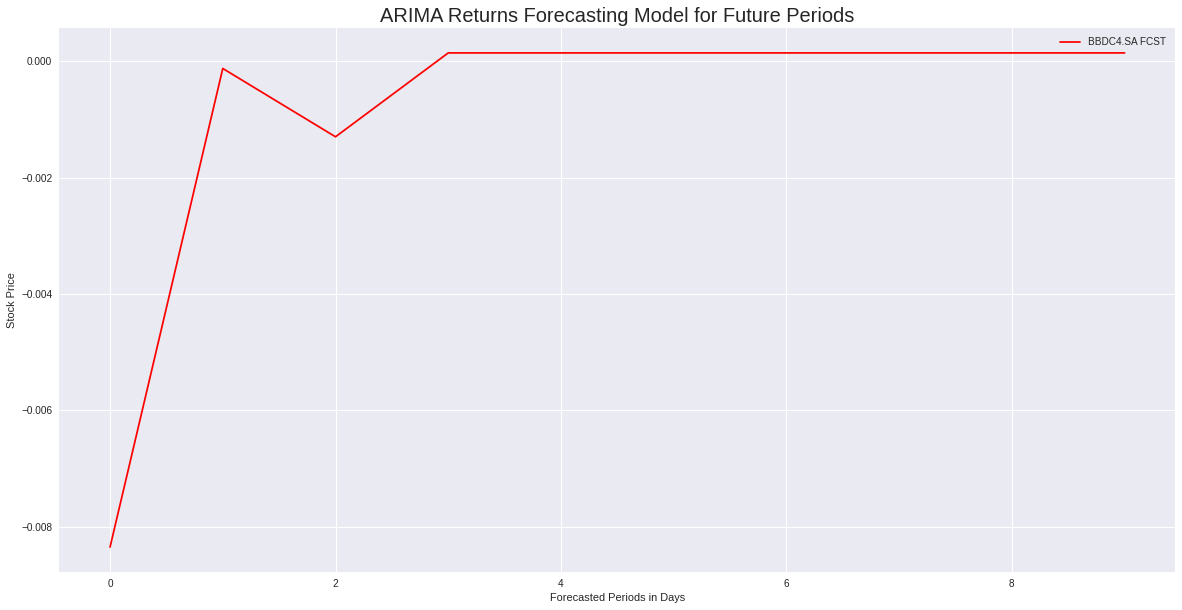

In [ ]:
# Define stock to be predicted & calculate percentage change to induce stationarity and turn it simple to return to price values
X = stocks[ticker].pct_change().dropna()

# Define Train Test Split manually
size = int(len(X) * 0.70)
arimatrain, arimatest = X[0:size], X[size:len(X)]

# Capture first price of  test series
# Index first price of the stock in the test set

X_val = stocks[ticker]

X_hist, X_price = train_test_split(X_val, train_size = .7 , shuffle = False)

# Stock price is the first price of the test set
stock_price = X_price.iloc[0]

# Augmented Dickey-Fuller Stationarity test

adf = pd.Series(X).dropna()
result = adfuller(adf)
print('ADF Statistic:', result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
  print("Reject H0 - Time Series is Stationary")
else:
  print ("Failed to Reject H0 - Time Series is Non-Stationary")

# Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

KPSS = pd.Series(X).dropna()
result = kpss(KPSS)
print('KPSS Statistic:', result[0])
print('p-value: %f' % result[1])
print('If the computed statistic is outside the table of critical values, then a warning message will be generated.')

# FIND & TRAIN THE BEST MODEL

# Define range test of parameters of the model
p=d=q=range(0,4)
pdq = list(itertools.product(p, d, q))

# Use AKAIKE INFORMATION CRITERIA (Lower value) to find best model
 
yhat_aic = list()  # store AIC results
par_aic = list()  # store Parameters

# Calculate model
for param in pdq :
  try:
     model_arima = ARIMA(arimatrain, order = param)
     model_arima_fit = model_arima.fit(disp = 0)
     yhat_aic.append(model_arima_fit.aic)
     par_aic.append(param)
     #print(param, model_arima_fit.aic)
  except:
     continue

# index regressions results to identify the best model
min_aic = pd.DataFrame()
min_aic["AIC"] = pd.Series(yhat_aic)
min_aic["pdq"] = pd.Series(par_aic)

bestmodel_pdq = min_aic.iloc[min_aic.AIC.idxmin()]

# Store Best Parameters
best_parameters = bestmodel_pdq[1]
p_bp = best_parameters[0]
d_bp = best_parameters[1]
q_bp = best_parameters[2]

# Model Parameters

print("ARIMA BEST MODEL AIC:", min_aic.AIC.min())
print("ARIMA AR (p) = ",int(best_parameters[0]))
print("ARIMA INT(d) = ",int(best_parameters[1]))
print("ARIMA MA (q) = ",int(best_parameters[2]))

# RUN MODEL fitting

model_arima = ARIMA(arimatrain, order = (p_bp, d_bp, q_bp))
model_arima_fit = model_arima.fit(disp = 0)

# Print Summary Info of the model
print(model_arima_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

# keep track of all observations in a list called history that 
# is seeded with the training data and to which new observations 
# are appended each iteration.
history = [x for x in arimatest]

# The same is done with forecasted values
arima_predictions = list()

# Run regression and forecast
for t in range(len(arimatest)):
	arimamodel = ARIMA(history, order=(p_bp, d_bp, q_bp)) # history provides the value
	arimamodel_fit = arimamodel.fit(disp=0)
	output = arimamodel_fit.forecast()
	yhat = output[0]
	arima_predictions.append(yhat)
	obs = arimatest[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))

# PRICE FORECAST
test = pd.DataFrame(arima_predictions).add(1).shift().cumprod().dropna()*stock_price
test.columns =[ticker+" FCST Price"]

# plot the figures calculated
plt.figure(figsize=(20,10))
plt.plot(test, color='red')
plt.title("ARIMA Model Predicted Price on Test Set", size= 20)
plt.show()

# plot the figures calculated
plt.figure(figsize=(20,10))
plt.plot(X_price, color='blue')
plt.title("ARIMA Model Real Price on Test Set", size= 20)
plt.show()

# Align and append Real and Predicted DataFrames
hist_df = pd.DataFrame(history).loc[len(pd.DataFrame(arima_predictions)):,:].reset_index()
hist_df[ticker+" fcst"] = pd.DataFrame(arima_predictions)
hist_df = hist_df.iloc[:,1:]
hist_df.columns = [ticker+" real", ticker+" fcst"]

# Plot Model Returns
hist_df.plot(figsize=(20,10))
plt.title("ARIMA Model Predicted Returns with Test Set Comparison", size= 20)
plt.show()

# Evaluate the error of the model
error = mean_squared_error(X_price[2:], test)
print('Test MSE: %.3f' % error)

# Forecasting periods ahead

# The same is done with forecasted values
arima_forecasting = list()

output_fcst = arimamodel_fit.forecast(steps=steps)
yhat_fcst = output_fcst[0]
arima_forecasting.append(yhat_fcst)

arimafcst = pd.DataFrame(arima_forecasting).T
arimafcst.columns = [ticker+' FCST']
arimafcst


# plot the figures calculated
arimafcst.plot(figsize=(20,10), color='red')
plt.title("ARIMA Returns Forecasting Model for Future Periods", size= 20)
plt.ylabel('Stock Price')
plt.xlabel("Forecasted Periods in Days")
plt.show()